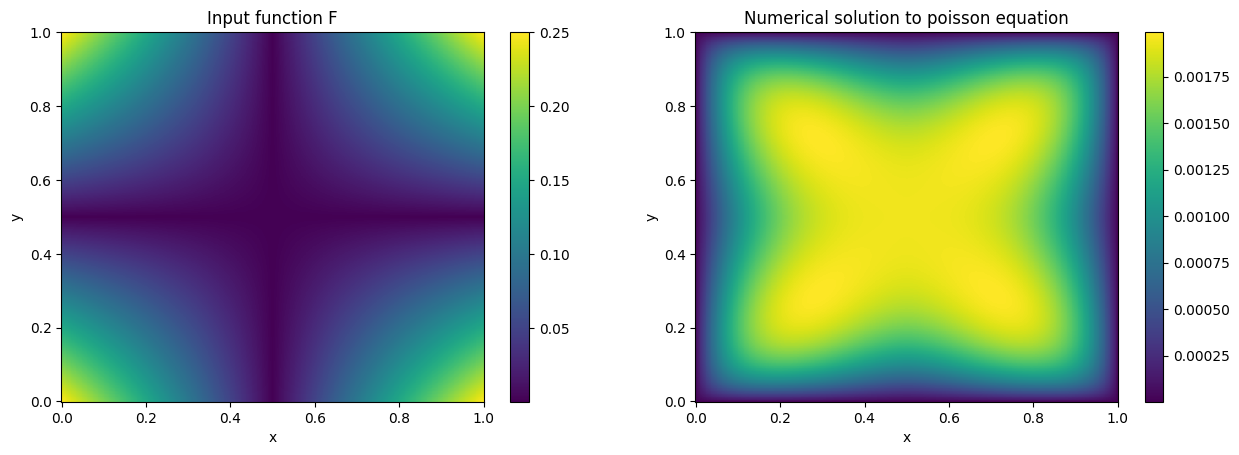

torch.Size([1, 1, 500, 500])


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg
import torch

N = 500
h = 1.0 / (N - 1)
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y)


#SEE FORM OF OPERATOR IN DATGEN PAPER, SOLVING Lu=-f

neumann = False

# Define f
F = np.abs(X- 0.5) * np.abs(Y-0.5)
#F = X - Y
#F = X**2 + Y**2
#F = X*Y


#redefine for numerical solver, which solves Lu = f, so have to redefine
F_num = -F

#numerical solver 

# Initialize the sparse matrix A
main_diagonal = np.ones(N**2) * -4 / h**2
offset_diagonals = np.ones(N**2 - 1) / h**2
offset_diagonals[N-1::N] = 0  # Fix the boundary effects where wrap-around occurs
far_diagonals = np.ones(N**2 - N) / h**2

# Create the sparse matrix A using diags
A = sp.diags(
    [main_diagonal, offset_diagonals, offset_diagonals, far_diagonals, far_diagonals],
    [0, -1, 1, -N, N], shape=(N**2, N**2), format='csr')

# Apply boundary conditions (zero boundary conditions applied by default)

if neumann:
    print(3)
    for i in range(N):
        if i == 0 or i == N-1:
            A[i,:] = A[-(i+1),:] = 0
            A[i,i] = A[-(i+1),-(i+1)] = 1/h
        if i % N == 0 or (i+1) % N == 0:
            A[i,:] = 0
            A[i,i] = 1/h

F_num = F_num.ravel()

if neumann:
    F_num[0:N] =F_num[-N:] = F_num[::N] = F_num[N-1::N] = 0

# Solve the linear system
u = scipy.sparse.linalg.spsolve(A, F_num)
U = u.reshape((N, N))


# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,F)
fig.colorbar(fig1)
axs[0].set_title("Input function F")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical solution to poisson equation")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()



#save input function

F = torch.tensor(F)[None,None,:]
print(F.shape)
torch.save(F,"../finput.pt")

In [2]:

import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO, FNO

#from neuralop.training import Trainer 

from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from neuralop.training import CheckpointCallback, BasicLoggerCallback
from neuralop.datasets.tensor_dataset import TensorDataset
from neuralop.datasets.output_encoder import UnitGaussianNormalizer
from neuralop.datasets.transforms import PositionalEmbedding2D
from neuralop.datasets.data_transforms import DefaultDataProcessor
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

print(device)

cuda


In [3]:
model = FNO(n_modes=(12, 12), hidden_channels=64,in_channels=3,non_linearity=F.relu,projection_channels=512,n_layers=6)
model = model.to(device)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 4204993 parameters.


In [4]:
a = 0
if a == 1:
    state_dict = torch.load("checkpoints_actual_1000_500/model_state_dict.pt")
    model.load_state_dict(state_dict)

In [5]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=0.001)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=25,gamma = 0.5)

# Creating the losses
#from CustomLoss import LpLoss
train_loss = LpLoss(d=2,p=2)

sys.stdout.flush()

In [12]:
#now for the data preparation process, following the darcy code

x_train = torch.load('../data_poisson/synthetic_data_dirichlet_10000_x2.pt').clone().type(torch.FloatTensor)
y_train = torch.load('../data_poisson/synthetic_data_dirichlet_10000_y2.pt').clone().type(torch.FloatTensor)
y_train = torch.unsqueeze(y_train,1).to(device)
grid_boundaries=[[0, 1], [0, 1]]


#data processing on training set
reduce_dims = list(range(x_train.ndim))
input_encoder = UnitGaussianNormalizer(dim=reduce_dims)
input_encoder.fit(x_train)


reduce_dims = list(range(y_train.ndim))
output_encoder = UnitGaussianNormalizer(dim=reduce_dims)
output_encoder.fit(y_train)




train_db = TensorDataset(
        x_train,
        y_train,
    )



train_loader = torch.utils.data.DataLoader(
        train_db,
        batch_size=100,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        persistent_workers=False,
    )


#this is where the two extra dimensions come from, the postiional encodings
pos_encoding = PositionalEmbedding2D(grid_boundaries=grid_boundaries)

data_processor = DefaultDataProcessor(
        in_normalizer=input_encoder,
        out_normalizer=output_encoder,
        positional_encoding=pos_encoding
    )
data_processor = data_processor.to(device)

In [7]:
#test set
x_test = torch.load('../data_poisson/synthetic_data_dirichlet_test_100_x2.pt').clone().type(torch.FloatTensor)
y_test = torch.load('../data_poisson/synthetic_data_dirichlet_test_100_y2.pt').clone().type(torch.FloatTensor)
y_test = torch.unsqueeze(y_test,1).to(device)
test_db = TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(
        test_db,
        batch_size=10,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        persistent_workers=False,
    )
test_loader = {"100":test_loader}
eval_loss = {"l2_test": train_loss}

In [8]:
# trainer = Trainer(model=model, n_epochs=31,
#                   device=device,
#                   callbacks=[
#                     CheckpointCallback(save_dir='./checkpoints',
#                                        save_interval=1,
#                                             save_optimizer=True,
#                                             save_scheduler=True)
#                         ],
#                   data_processor=None,
#                   wandb_log=False,
#                   log_test_interval=3,
#                   use_distributed=False,
#                   verbose=True)


from CustomCallback import BasicLoggerCallback2
from CustomTrainer import Trainer

callback = BasicLoggerCallback2()
ckpt = CheckpointCallback(save_dir='./checkpoints',
                                       save_interval=10,
                                            save_optimizer=True, 
                                            save_scheduler=True)
trainer = Trainer(model=model, n_epochs=101,
                  device=device,
                  callbacks=[callback,ckpt],
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=1,
                  use_distributed=False,
                  verbose=True)

using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


In [9]:

trainer.train(train_loader=train_loader,
              test_loaders=test_loader,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=None, 
              training_loss=train_loss,
              eval_losses=eval_loss
              )

Training on 10000 samples
Testing on [100] samples         on resolutions ['100'].
Raw outputs of size out.shape=torch.Size([100, 1, 100, 100])
[0] time=43.62, avg_loss=1.2348, train_err=123.4838, 100_l2_test=0.7105
Successfully saved training state to checkpoints
Saved training state to checkpoints
[1] time=41.25, avg_loss=0.8002, train_err=80.0226, 100_l2_test=0.9844
[2] time=41.14, avg_loss=0.9269, train_err=92.6944, 100_l2_test=1.5443
[3] time=41.15, avg_loss=1.1896, train_err=118.9604, 100_l2_test=0.6679
[4] time=41.16, avg_loss=0.7452, train_err=74.5234, 100_l2_test=1.7649
[5] time=41.19, avg_loss=1.1955, train_err=119.5533, 100_l2_test=1.0010
[6] time=41.15, avg_loss=0.8566, train_err=85.6612, 100_l2_test=0.6926
[7] time=41.32, avg_loss=0.8890, train_err=88.8977, 100_l2_test=0.5196
[8] time=41.16, avg_loss=0.8302, train_err=83.0249, 100_l2_test=0.7185
[9] time=41.16, avg_loss=0.7322, train_err=73.2162, 100_l2_test=1.3992
[10] time=41.25, avg_loss=0.9301, train_err=93.0097, 100_l

{'100_l2_test': 0.059137874841690065}

C:\Users\frase\AppData\Local\Temp\ipykernel_23976\475119263.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


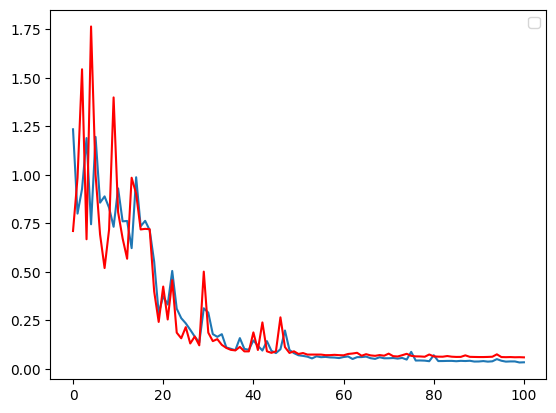

In [10]:
plt.plot(np.arange(0,101,1),callback.loss,"-")
plt.plot(np.arange(0,101,1),callback.val_loss,"-r")
plt.legend()
plt.show()

torch.Size([1, 1, 500, 500])
torch.Size([1, 1, 500, 500])
tensor(1.3169, dtype=torch.float64)


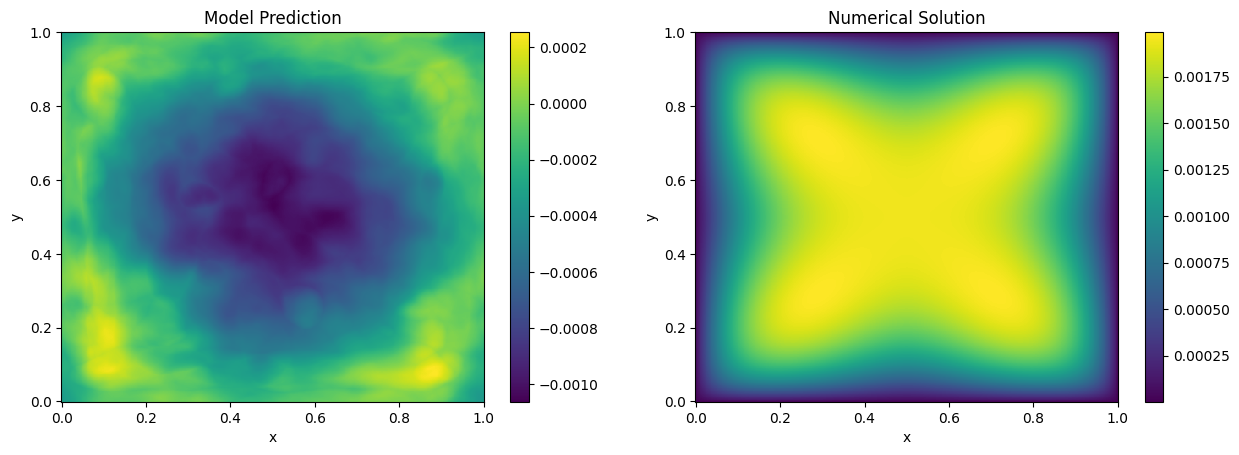

In [13]:
#prediction time
sample = torch.load("../finput.pt").clone().type(torch.FloatTensor).to(device)
sample = {"x": sample, "y": sample}
print(sample["x"].shape)
#preprocessing


sample = data_processor.preprocess(sample)
x = sample["x"]


out = model(x)
print(out.shape)


out= data_processor.postprocess(out,sample)[0].cpu().detach().numpy()[0,0,:,:]



print(train_loss(torch.tensor(out),torch.tensor(U)))



# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(15)

fig1 = axs[0].pcolormesh(X,Y,out)
fig.colorbar(fig1)
axs[0].set_title("Model Prediction")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")



fig2 = axs[1].pcolormesh(X,Y,U)
fig.colorbar(fig2)
axs[1].set_title("Numerical Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()
